# Import Library

In [16]:
pip install yfinance


In [17]:
# Load data
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preparation
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Modelling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Inference & save model
import json
from datetime import datetime
import tensorflow as tf
import joblib


# Load data

In [18]:
def get_gbpusd_data(start_date='2015-01-01', end_date=None, csv_path='gbpusd_data.csv', force_download=False, delay=5):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    if not force_download and os.path.exists(csv_path):
        print(f"Membaca data dari cache: {csv_path}")
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    else:
        print(f"Mengunduh data GBP/USD dari Yahoo Finance: {start_date} sampai {end_date}")
        time.sleep(delay)
        data = yf.download('GBPUSD=X', start=start_date, end=end_date)

        # Ambil hanya 5 kolom yang diinginkan
        columns_to_keep = ['Close', 'High', 'Low', 'Open', 'Volume']
        data = data[columns_to_keep]

        # Ganti nama kolom sesuai urutan (agar mudah pada data preparation)
        data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

        data.to_csv(csv_path)
        print(f"Data disimpan ke {csv_path}")

    return data

data = get_gbpusd_data(end_date=None)  # end_date=None untuk hari ini


Membaca data dari cache: gbpusd_data.csv


# EDA

## Cek missing value & duplikat

In [19]:
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [20]:
data.duplicated().sum()

np.int64(0)

## Meneliti 5 data terakhir

In [21]:
data.tail()

,Close,High,Low,Open,Volume
Date,,,,,
2025-06-02,1.346729,1.355969,1.346946,1.346946,0
2025-06-03,1.355675,1.355822,1.349473,1.355730,0
2025-06-04,1.353143,1.358105,1.350257,1.353162,0
2025-06-05,1.355216,1.361730,1.354133,1.355179,0
2025-06-06,1.357958,1.358541,1.350804,1.357995,0


## Meneliti dimensi dataset

In [22]:
print("Dimensi dataset:", data.shape)

Dimensi dataset: (2716, 5)


## Meneliti nilai

In [23]:
data.describe()

,Close,High,Low,Open,Volume
count,2716.000000,2716.000000,2716.000000,2716.000000,2716.0
mean,1.319293,1.324003,1.314288,1.319276,0.0
std,0.092938,0.092884,0.092934,0.092935,0.0
min,1.072754,1.083541,1.037904,1.072846,0.0
25%,1.257047,1.261091,1.251862,1.257178,0.0
50%,1.299849,1.303815,1.295043,1.299841,0.0
75%,1.360776,1.364438,1.356470,1.360813,0.0
max,1.588512,1.593143,1.583732,1.588007,0.0


### Insight :    
- Nilai volume 0, karena pasangan USD sering tidak ditampilkan data nya oleh beberapa pihak, salah satunya platform sumber kami yaitu Yahoo Finance
- Volume akan dihapus karena tidak memiliki pengaruh pada time series, karena tidak ada datanya.

## Visualisasi Tren Harga

<Axes: title={'center': 'GBP/USD Closing Price'}, xlabel='Date'>

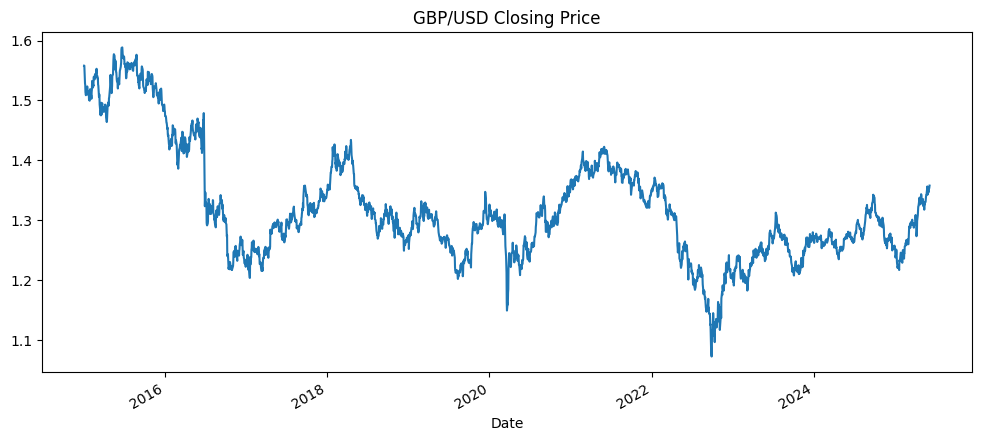

In [24]:
data['Close'].plot(figsize=(12, 5), title='GBP/USD Closing Price')

## Seasonality & Trend

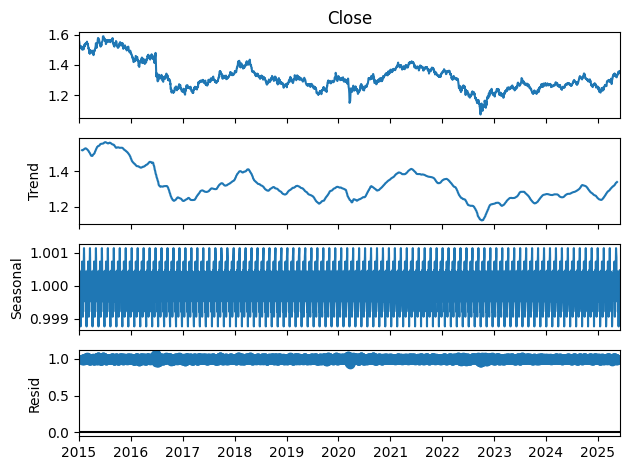

In [25]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)
result.plot();

### Insight :     
- GBP/USD memiliki fluktuasi tren jangka panjang
- Penurunan tren masih terjadi sejak 2015 hingga sekarang (2025)
- Fluktuasi seasonal cukup kecil dalam skala.
- 2022 akhir GBP/USD mengalami titik terendah sejak 2015. Kemungkinan besar karena efek pandemi corona.
- Terdapat fase tren naik dan turun yang cukup panjang, cocok untuk digunakan dalam strategi long-term trading atau hedging.

## Boxplot

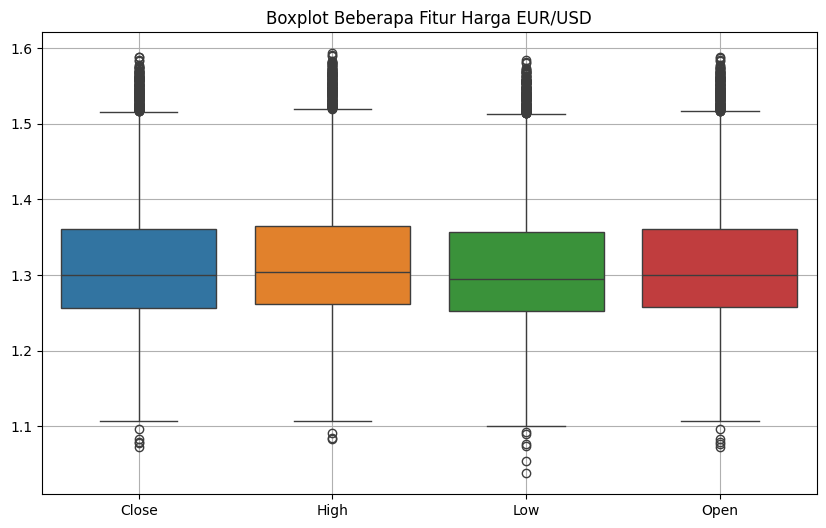

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Close', 'High', 'Low', 'Open']])
plt.title("Boxplot Beberapa Fitur Harga EUR/USD")
plt.grid(True)
plt.show()

### Insight :
- Distribusi merata, ada beberapa outlier namun masih bisa di tolerisasi
- Outlier tersebut bisa saja high spike pada momentum tertentu dengan faktor fundamental, teknikal, dan sentimen pasar

# Data Preprocessing

In [27]:
# 1. Memastikan index dataframe adalah date
print(data.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12',
               '2015-01-13', '2015-01-14',
               ...
               '2025-05-26', '2025-05-27', '2025-05-28', '2025-05-29',
               '2025-05-30', '2025-06-02', '2025-06-03', '2025-06-04',
               '2025-06-05', '2025-06-06'],
              dtype='datetime64[ns]', name='Date', length=2716, freq=None)


In [28]:
# 2. Menghapus kolom volume
data.drop(columns=['Volume'], inplace=True)

# 3. Hitung perubahan harga harian (Price Change)
data['Price_Change'] = data['Close'].diff().fillna(0)

# 4. Klasifikasi perubahan harga (Price Range Class)
def classify_price_range(change):
    if change <= -0.01:
        return 'turunjauh'
    elif change <= -0.001:
        return 'turundekat'
    elif change > 0.01:
        return 'naikjauh'
    elif change > 0.001:
        return 'naikdekat'
    else:
        return 'stabil'

# 5. Klasifikasi range high-low harian (Volatilitas)
def classify_high_low_range(row):
    hl_range = row['High'] - row['Low']
    if hl_range > 0.01:
        return 'rangebesar'
    elif hl_range > 0.001:
        return 'rangesedang'
    elif hl_range > 0.0001:
        return 'rangekecil'
    else:
        return 'rangetipis'

data['Price_Range_Class'] = data['Price_Change'].apply(classify_price_range)
data['High_Low_Range_Class'] = data.apply(classify_high_low_range, axis=1)

# 6. Hitung RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])

# 7. Moving Averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# 8. Hitung MACD
def compute_macd(series, fast_period=12, slow_period=26, signal_period=9):
    exp1 = series.ewm(span=fast_period, adjust=False).mean()
    exp2 = series.ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['MACD_Signal'] = compute_macd(data['Close'])

# 9. Drop NA rows (karena MA dan RSI awal akan kosong)
data.dropna(inplace=True)

In [29]:
# Meneliti 5 data terakhir setelah menambahkan fitur baru
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,Price_Range_Class,High_Low_Range_Class,RSI,MA_5,MA_10,MACD,MACD_Signal
Date,,,,,,,,,,,,
2025-06-02,1.346729,1.355969,1.346946,1.346946,-0.003170,turundekat,rangesedang,70.528386,1.349526,1.346082,0.008265,0.008143
2025-06-03,1.355675,1.355822,1.349473,1.355730,0.008946,naikdekat,rangesedang,68.890268,1.349357,1.348049,0.008605,0.008236
2025-06-04,1.353143,1.358105,1.350257,1.353162,-0.002532,turundekat,rangesedang,70.540393,1.349719,1.349386,0.008571,0.008303
2025-06-05,1.355216,1.361730,1.354133,1.355179,0.002072,naikdekat,rangesedang,69.478410,1.352132,1.350717,0.008613,0.008365
2025-06-06,1.357958,1.358541,1.350804,1.357995,0.002742,naikdekat,rangesedang,70.903195,1.353744,1.352320,0.008766,0.008445


# Data Preparation

In [30]:
# 1. Membuat target NAIK/TURUN t+1 s.d. t+5 (senin-jum'at)
for offset in range(1, 6):
    data[f'Close_t+{offset}'] = data['Close'].shift(-offset)
    data[f'Target_t+{offset}'] = (data[f'Close_t+{offset}'] > data['Close']).astype(int)

data.dropna(inplace=True)

In [31]:
# 2. Normalisasi numerik
scaler = MinMaxScaler()
data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']] = scaler.fit_transform(data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']])

# 3. One-hot encoding
data = pd.get_dummies(data, columns=['Price_Range_Class', 'High_Low_Range_Class'])

# 4. Sequence LSTM
window_size = 90  # Bisa dioptimalkan nanti
features = data.drop(columns=[f'Close_t+{i}' for i in range(1, 6)] + [f'Target_t+{i}' for i in range(1, 6)]).values
targets = data[[f'Target_t+{i}' for i in range(1, 6)]].values

X, y = [], []
for i in range(len(features) - window_size):
    X.append(features[i:i+window_size])
    y.append(targets[i+window_size])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

In [32]:
# Meneliti 5 data terakhir setelah normalisasi
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,RSI,MA_5,MA_10,MACD,MACD_Signal,...,Close_t+5,Target_t+5,Price_Range_Class_naikdekat,Price_Range_Class_naikjauh,Price_Range_Class_stabil,Price_Range_Class_turundekat,Price_Range_Class_turunjauh,High_Low_Range_Class_rangebesar,High_Low_Range_Class_rangesedang,High_Low_Range_Class_rangetipis
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-26,0.544497,1.359287,1.353766,1.353785,0.011661,0.678325,0.515641,0.484619,0.804109,0.007112,...,1.346729,0,False,True,False,False,False,False,True,False
2025-05-27,0.550194,1.358714,1.350147,1.356668,0.002938,0.660755,0.523887,0.492849,0.820434,0.007481,...,1.355675,0,True,False,False,False,False,False,True,False
2025-05-28,0.540135,1.352247,1.345116,1.351516,-0.005188,0.670318,0.528530,0.497287,0.824478,0.007825,...,1.353143,1,False,False,False,True,False,False,True,False
2025-05-29,0.524264,1.350749,1.342102,1.342696,-0.008186,0.648423,0.529030,0.500856,0.814801,0.007986,...,1.355216,1,False,False,False,True,False,False,True,False
2025-05-30,0.537355,1.351151,1.345098,1.349965,0.006752,0.655874,0.532236,0.504937,0.814682,0.008113,...,1.357958,1,True,False,False,False,False,False,True,False


In [33]:
# 5. Menyiapkan data untuk model klasifikasi dan regresi
data_cls = data.copy()
data_reg = data.copy()

In [34]:
# 6. Target regresi (harga penutupan)
regression_targets = data_reg[[f'Close_t+{i}' for i in range(1, 6)]].values

# Menggunakan fitur yang sama
X_reg = []
y_reg = []
for i in range(len(features) - window_size):
    X_reg.append(features[i:i+window_size])
    y_reg.append(regression_targets[i+window_size])

X_reg = np.array(X_reg).astype(np.float32)
y_reg = np.array(y_reg).astype(np.float32)

# Modelling

## Klasifikasi (Naik/Turun)

### Split Data

In [35]:
# Split Data
X_cls = np.array(X).astype(np.float32)
y_cls = np.array(y).astype(np.int32)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )

### Build Model

In [36]:
# Build Model
model_cls = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(5, activation='sigmoid')  # output 5 hari
])

model_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cls.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,829 (132.14 KB)

 Trainable params: 33,829 (132.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [37]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_cls = ModelCheckpoint('best_model_cls.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model_cls.fit(
    X_train_cls, y_train_cls,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_cls],
    verbose=1
)

Epoch 1/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2141 - loss: 0.6983
Epoch 1: val_loss improved from inf to 0.69203, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.2147 - loss: 0.6983 - val_accuracy: 0.0455 - val_loss: 0.6920
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2451 - loss: 0.6958
Epoch 2: val_loss did not improve from 0.69203
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - accuracy: 0.2457 - loss: 0.6958 - val_accuracy: 0.0789 - val_loss: 0.6924
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2198 - loss: 0.6925
Epoch 3: val_loss did not improve from 0.69203
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2205 - loss: 0.6925 - val_accuracy: 0.2368 - val_loss: 0.6947
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3255 - loss: 0.6930
Epoch 4: val_loss improved from 0.69203 to 0.69172, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3253 - loss: 0.6930 - val_accuracy: 0.4282 - val_loss: 0.6917
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3217 - loss: 0.6928
Epoch 5: val_loss did not improve from 0.69172
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.3223 - loss: 0.6928 - val_accuracy: 0.5909 - val_loss: 0.6921
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.5008 - loss: 0.6887
Epoch 6: val_loss did not improve from 0.69172
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - accuracy: 0.4983 - loss: 0.6887 - val_accuracy: 0.0287 - val_loss: 0.6932
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2302 - loss: 0.6929
Epoch 7: val_loss improved from 0.69172 to 0.68943, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2314 - loss: 0.6929 - val_accuracy: 0.2943 - val_loss: 0.6894
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4252 - loss: 0.6916
Epoch 8: val_loss did not improve from 0.68943
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.4259 - loss: 0.6916 - val_accuracy: 0.4665 - val_loss: 0.6916
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1944 - loss: 0.6897
Epoch 9: val_loss improved from 0.68943 to 0.68911, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.1951 - loss: 0.6897 - val_accuracy: 0.3110 - val_loss: 0.6891
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3389 - loss: 0.6903
Epoch 10: val_loss improved from 0.68911 to 0.68817, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 100ms/step - accuracy: 0.3387 - loss: 0.6903 - val_accuracy: 0.3732 - val_loss: 0.6882
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3542 - loss: 0.6848
Epoch 11: val_loss improved from 0.68817 to 0.68677, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.3547 - loss: 0.6849 - val_accuracy: 0.2799 - val_loss: 0.6868
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3880 - loss: 0.6873
Epoch 12: val_loss improved from 0.68677 to 0.68634, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3884 - loss: 0.6873 - val_accuracy: 0.1986 - val_loss: 0.6863
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.2048 - loss: 0.6835
Epoch 13: val_loss improved from 0.68634 to 0.68451, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.2050 - loss: 0.6836 - val_accuracy: 0.2464 - val_loss: 0.6845
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2672 - loss: 0.6817
Epoch 14: val_loss did not improve from 0.68451
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2675 - loss: 0.6817 - val_accuracy: 0.3373 - val_loss: 0.6847
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3949 - loss: 0.6831
Epoch 15: val_loss did not improve from 0.68451
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.3937 - loss: 0.6831 - val_accuracy: 0.2273 - val_loss: 0.6865
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2689 - loss: 0.6804
Epoch 16: val_loss did not improve from 0.68451
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.2684 - loss: 0.6804 - val_accuracy: 0.2273 - val_loss: 0.6860
Epoch 17/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2962 - loss: 0.6806
Epoch 17: val_loss did not improve from 0

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.3082 - loss: 0.6785 - val_accuracy: 0.1938 - val_loss: 0.6835
Epoch 19/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.2716 - loss: 0.6832
Epoch 19: val_loss improved from 0.68353 to 0.68352, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2721 - loss: 0.6831 - val_accuracy: 0.2751 - val_loss: 0.6835
Epoch 20/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2425 - loss: 0.6771
Epoch 20: val_loss improved from 0.68352 to 0.68180, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.2425 - loss: 0.6771 - val_accuracy: 0.2560 - val_loss: 0.6818
Epoch 21/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2771 - loss: 0.6696
Epoch 21: val_loss did not improve from 0.68180
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.2774 - loss: 0.6697 - val_accuracy: 0.2536 - val_loss: 0.6819
Epoch 22/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.2596 - loss: 0.6700
Epoch 22: val_loss improved from 0.68180 to 0.68124, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.2592 - loss: 0.6701 - val_accuracy: 0.1962 - val_loss: 0.6812
Epoch 23/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2484 - loss: 0.6653
Epoch 23: val_loss did not improve from 0.68124
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.2492 - loss: 0.6655 - val_accuracy: 0.2273 - val_loss: 0.6823
Epoch 24/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2651 - loss: 0.6657
Epoch 24: val_loss did not improve from 0.68124
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2655 - loss: 0.6657 - val_accuracy: 0.3517 - val_loss: 0.6830
Epoch 25/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2892 - loss: 0.6617
Epoch 25: val_loss improved from 0.68124 to 0.67554, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.2888 - loss: 0.6618 - val_accuracy: 0.2057 - val_loss: 0.6755
Epoch 26/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.2990 - loss: 0.6739
Epoch 26: val_loss did not improve from 0.67554
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.2989 - loss: 0.6737 - val_accuracy: 0.2751 - val_loss: 0.6793
Epoch 27/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3152 - loss: 0.6691
Epoch 27: val_loss did not improve from 0.67554
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3143 - loss: 0.6692 - val_accuracy: 0.2153 - val_loss: 0.6804
Epoch 28/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.2510 - loss: 0.6591
Epoch 28: val_loss improved from 0.67554 to 0.67188, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - accuracy: 0.2511 - loss: 0.6592 - val_accuracy: 0.1555 - val_loss: 0.6719
Epoch 29/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.2645 - loss: 0.6573
Epoch 29: val_loss improved from 0.67188 to 0.66893, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.2646 - loss: 0.6573 - val_accuracy: 0.2608 - val_loss: 0.6689
Epoch 30/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.2452 - loss: 0.6644
Epoch 30: val_loss did not improve from 0.66893
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.2456 - loss: 0.6643 - val_accuracy: 0.1986 - val_loss: 0.6714
Epoch 31/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2694 - loss: 0.6546
Epoch 31: val_loss did not improve from 0.66893
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 98ms/step - accuracy: 0.2696 - loss: 0.6547 - val_accuracy: 0.3110 - val_loss: 0.6699
Epoch 32/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3030 - loss: 0.6540
Epoch 32: val_loss improved from 0.66893 to 0.66603, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.3030 - loss: 0.6538 - val_accuracy: 0.2297 - val_loss: 0.6660
Epoch 33/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2640 - loss: 0.6514
Epoch 33: val_loss did not improve from 0.66603
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.2638 - loss: 0.6513 - val_accuracy: 0.2727 - val_loss: 0.6781
Epoch 34/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3482 - loss: 0.6354
Epoch 34: val_loss did not improve from 0.66603
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.3476 - loss: 0.6356 - val_accuracy: 0.2584 - val_loss: 0.6705
Epoch 35/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2782 - loss: 0.6405
Epoch 35: val_loss did not improve from 0.66603
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.2783 - loss: 0.6405 - val_accuracy: 0.2727 - val_loss: 0.6731
Epoch 36/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3342 - loss: 0.6279
Epoch 36: val_loss improved from 0.66603 to

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.3339 - loss: 0.6280 - val_accuracy: 0.2656 - val_loss: 0.6594
Epoch 37/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2734 - loss: 0.6159
Epoch 37: val_loss did not improve from 0.65937
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.2732 - loss: 0.6161 - val_accuracy: 0.2560 - val_loss: 0.6708
Epoch 38/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2757 - loss: 0.6232
Epoch 38: val_loss did not improve from 0.65937
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.2759 - loss: 0.6232 - val_accuracy: 0.3923 - val_loss: 0.6930
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3003 - loss: 0.6354
Epoch 39: val_loss did not improve from 0.65937
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.2997 - loss: 0.6353 - val_accuracy: 0.2321 - val_loss: 0.6606
Epoch 40/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2429 - loss: 0.6291
Epoch 40: val_loss did not improve from 0.6

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3331 - loss: 0.6184 - val_accuracy: 0.3086 - val_loss: 0.6560
Epoch 42/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2968 - loss: 0.6114
Epoch 42: val_loss did not improve from 0.65597
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2971 - loss: 0.6114 - val_accuracy: 0.3134 - val_loss: 0.6638
Epoch 43/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3198 - loss: 0.5993
Epoch 43: val_loss did not improve from 0.65597
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.3198 - loss: 0.5993 - val_accuracy: 0.3517 - val_loss: 0.6654
Epoch 44/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3265 - loss: 0.6033
Epoch 44: val_loss did not improve from 0.65597
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.3264 - loss: 0.6032 - val_accuracy: 0.2823 - val_loss: 0.6565
Epoch 45/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3019 - loss: 0.6001
Epoch 45: val_loss did not improve from 0.

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.3605 - loss: 0.5832 - val_accuracy: 0.2727 - val_loss: 0.6428
Epoch 48/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.2772 - loss: 0.5798
Epoch 48: val_loss did not improve from 0.64276
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.2776 - loss: 0.5797 - val_accuracy: 0.3254 - val_loss: 0.6653
Epoch 49/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3306 - loss: 0.5713
Epoch 49: val_loss did not improve from 0.64276
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.3304 - loss: 0.5714 - val_accuracy: 0.2990 - val_loss: 0.6630
Epoch 50/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3096 - loss: 0.5952
Epoch 50: val_loss improved from 0.64276 to 0.63895, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3093 - loss: 0.5952 - val_accuracy: 0.2847 - val_loss: 0.6390
Epoch 51/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.2683 - loss: 0.5652
Epoch 51: val_loss did not improve from 0.63895
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.2688 - loss: 0.5651 - val_accuracy: 0.3325 - val_loss: 0.6416
Epoch 52/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3289 - loss: 0.5519
Epoch 52: val_loss did not improve from 0.63895
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3290 - loss: 0.5522 - val_accuracy: 0.3469 - val_loss: 0.6577
Epoch 53/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3416 - loss: 0.5590
Epoch 53: val_loss did not improve from 0.63895
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.3413 - loss: 0.5590 - val_accuracy: 0.2990 - val_loss: 0.6451
Epoch 54/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3341 - loss: 0.5537
Epoch 54: val_loss did not improve from 0.6

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.3319 - loss: 0.5342 - val_accuracy: 0.3014 - val_loss: 0.6381
Epoch 59/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3402 - loss: 0.5291
Epoch 59: val_loss did not improve from 0.63810
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3401 - loss: 0.5291 - val_accuracy: 0.3493 - val_loss: 0.6510
Epoch 60/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3464 - loss: 0.5145
Epoch 60: val_loss improved from 0.63810 to 0.62280, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.3462 - loss: 0.5145 - val_accuracy: 0.2823 - val_loss: 0.6228
Epoch 61/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3260 - loss: 0.5108
Epoch 61: val_loss did not improve from 0.62280
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3263 - loss: 0.5109 - val_accuracy: 0.3493 - val_loss: 0.6326
Epoch 62/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3393 - loss: 0.4987
Epoch 62: val_loss did not improve from 0.62280
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.3397 - loss: 0.4988 - val_accuracy: 0.3469 - val_loss: 0.6380
Epoch 63/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3346 - loss: 0.5069
Epoch 63: val_loss did not improve from 0.62280
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.3347 - loss: 0.5068 - val_accuracy: 0.3565 - val_loss: 0.6517
Epoch 64/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3452 - loss: 0.5054
Epoch 64: val_loss improved from 0.62280 to

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.3456 - loss: 0.5053 - val_accuracy: 0.3517 - val_loss: 0.6198
Epoch 65/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3365 - loss: 0.4836
Epoch 65: val_loss did not improve from 0.61977
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.3366 - loss: 0.4838 - val_accuracy: 0.3469 - val_loss: 0.6355
Epoch 66/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3583 - loss: 0.4807
Epoch 66: val_loss improved from 0.61977 to 0.61040, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 112ms/step - accuracy: 0.3583 - loss: 0.4809 - val_accuracy: 0.3325 - val_loss: 0.6104
Epoch 67/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3283 - loss: 0.4920
Epoch 67: val_loss did not improve from 0.61040
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.3285 - loss: 0.4920 - val_accuracy: 0.3565 - val_loss: 0.6383
Epoch 68/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3709 - loss: 0.4781
Epoch 68: val_loss did not improve from 0.61040
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.3706 - loss: 0.4783 - val_accuracy: 0.3278 - val_loss: 0.6219
Epoch 69/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3274 - loss: 0.4869
Epoch 69: val_loss did not improve from 0.61040
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3277 - loss: 0.4868 - val_accuracy: 0.3636 - val_loss: 0.6281
Epoch 70/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.3642 - loss: 0.4859
Epoch 70: val_loss improved from 0.61040 t

53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.3643 - loss: 0.4859 - val_accuracy: 0.3325 - val_loss: 0.6037
Epoch 71/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3501 - loss: 0.4794
Epoch 71: val_loss improved from 0.60370 to 0.59892, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.3504 - loss: 0.4794 - val_accuracy: 0.3469 - val_loss: 0.5989
Epoch 72/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3399 - loss: 0.4600
Epoch 72: val_loss did not improve from 0.59892
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - accuracy: 0.3400 - loss: 0.4601 - val_accuracy: 0.3421 - val_loss: 0.6147
Epoch 73/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3604 - loss: 0.4867
Epoch 73: val_loss did not improve from 0.59892
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - accuracy: 0.3602 - loss: 0.4866 - val_accuracy: 0.3301 - val_loss: 0.6059
Epoch 74/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3340 - loss: 0.4638
Epoch 74: val_loss did not improve from 0.59892
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - accuracy: 0.3344 - loss: 0.4639 - val_accuracy: 0.3349 - val_loss: 0.6152
Epoch 75/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3547 - loss: 0.4791
Epoch 75: val_loss improved from 0.59892 t

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.3550 - loss: 0.4790 - val_accuracy: 0.3517 - val_loss: 0.5977
Epoch 76/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3374 - loss: 0.5023
Epoch 76: val_loss did not improve from 0.59770
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - accuracy: 0.3376 - loss: 0.5022 - val_accuracy: 0.3421 - val_loss: 0.6223
Epoch 77/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3498 - loss: 0.4839
Epoch 77: val_loss did not improve from 0.59770
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3498 - loss: 0.4838 - val_accuracy: 0.3421 - val_loss: 0.6042
Epoch 78/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3578 - loss: 0.4628
Epoch 78: val_loss did not improve from 0.59770
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3576 - loss: 0.4629 - val_accuracy: 0.3325 - val_loss: 0.6029
Epoch 79/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3388 - loss: 0.4474
Epoch 79: val_loss did not improve from 0

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.3506 - loss: 0.4636 - val_accuracy: 0.3589 - val_loss: 0.5934
Epoch 81/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.3739 - loss: 0.4289
Epoch 81: val_loss did not improve from 0.59344
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - accuracy: 0.3738 - loss: 0.4292 - val_accuracy: 0.3349 - val_loss: 0.5972
Epoch 82/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3465 - loss: 0.4465
Epoch 82: val_loss did not improve from 0.59344
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.3467 - loss: 0.4466 - val_accuracy: 0.3756 - val_loss: 0.6003
Epoch 83/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3611 - loss: 0.4370
Epoch 83: val_loss did not improve from 0.59344
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.3610 - loss: 0.4371 - val_accuracy: 0.3612 - val_loss: 0.6093
Epoch 84/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3931 - loss: 0.4267
Epoch 84: val_loss did not improve from 0.

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.3675 - loss: 0.4438 - val_accuracy: 0.3541 - val_loss: 0.5901
Epoch 86/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3617 - loss: 0.4462
Epoch 86: val_loss did not improve from 0.59013
53/53 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.3618 - loss: 0.4463 - val_accuracy: 0.3541 - val_loss: 0.6007
Epoch 87/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3623 - loss: 0.4238
Epoch 87: val_loss improved from 0.59013 to 0.58625, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - accuracy: 0.3623 - loss: 0.4241 - val_accuracy: 0.3373 - val_loss: 0.5862
Epoch 88/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3692 - loss: 0.4336
Epoch 88: val_loss did not improve from 0.58625
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.3689 - loss: 0.4335 - val_accuracy: 0.3373 - val_loss: 0.5994
Epoch 89/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.3554 - loss: 0.4255
Epoch 89: val_loss did not improve from 0.58625
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.3556 - loss: 0.4256 - val_accuracy: 0.3301 - val_loss: 0.5920
Epoch 90/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3548 - loss: 0.4285
Epoch 90: val_loss did not improve from 0.58625
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.3549 - loss: 0.4286 - val_accuracy: 0.3589 - val_loss: 0.6185
Epoch 91/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3732 - loss: 0.4359
Epoch 91: val_loss did not improve from 0.

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.3878 - loss: 0.4195 - val_accuracy: 0.3612 - val_loss: 0.5821
Epoch 96/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3636 - loss: 0.4108
Epoch 96: val_loss did not improve from 0.58213
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.3636 - loss: 0.4110 - val_accuracy: 0.3397 - val_loss: 0.5829
Epoch 97/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3811 - loss: 0.4272
Epoch 97: val_loss did not improve from 0.58213
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 114ms/step - accuracy: 0.3811 - loss: 0.4272 - val_accuracy: 0.3397 - val_loss: 0.5886
Epoch 98/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.3729 - loss: 0.4088
Epoch 98: val_loss improved from 0.58213 to 0.57400, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.3730 - loss: 0.4091 - val_accuracy: 0.3373 - val_loss: 0.5740
Epoch 99/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3711 - loss: 0.4055
Epoch 99: val_loss did not improve from 0.57400
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3712 - loss: 0.4057 - val_accuracy: 0.3421 - val_loss: 0.5922
Epoch 100/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3721 - loss: 0.4279
Epoch 100: val_loss did not improve from 0.57400
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.3722 - loss: 0.4280 - val_accuracy: 0.3493 - val_loss: 0.5906


### Evaluation

In [38]:
# Load model terbaik dari file checkpoint
model = load_model('best_model_cls.h5')

y_pred_probs = model.predict(X_test_cls)
y_pred = (y_pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report

for i in range(5):
    print(f"\n📈 t+{i+1} Classification Report:")
    print(classification_report(y_test_cls[:, i], y_pred[:, i]))

# Evaluasi loss dan akurasi
loss, acc = model.evaluate(X_test_cls, y_test_cls, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

📈 t+1 Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.65       264
           1       0.64      0.63      0.63       258

    accuracy                           0.64       522
   macro avg       0.64      0.64      0.64       522
weighted avg       0.64      0.64      0.64       522


📈 t+2 Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       263
           1       0.69      0.69      0.69       259

    accuracy                           0.69       522
   macro avg       0.69      0.69      0.69       522
weighted avg       0.69      0.69      0.69       522


📈 t+3 Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.77      0.75       265
           1       0.75      0.72      0.73       257

    accuracy                           0.74       52

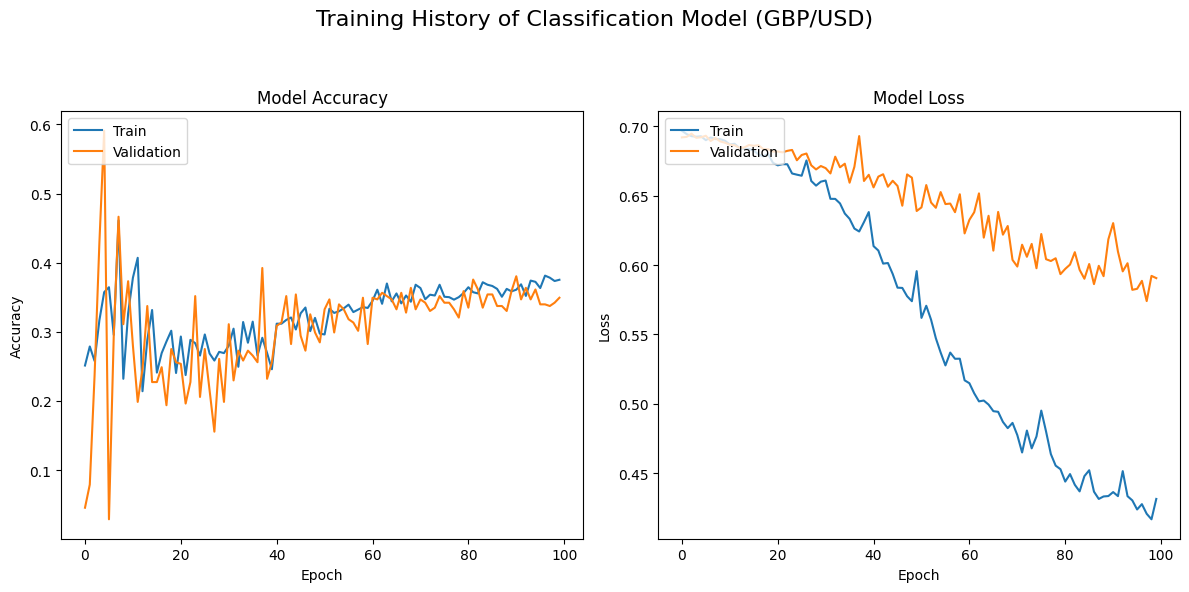

In [39]:
# Visualize training history (Classification Model)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tambahkan title utama
plt.suptitle('Training History of Classification Model (GBP/USD)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # beri ruang untuk suptitle
plt.show()


### Save Model

In [48]:
# save model
model_cls.save('GBPUSD_model_cls.h5')
# save scaler
joblib.dump(scaler, 'GBPUSD_scaler.save')

['GBPUSD_scaler.save']

## Regresi

### Split Data

In [41]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
    )


### Build Model

In [42]:
# Arsitektur model LSTM untuk regresi 5 output
model_reg = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5)  # Output untuk Close_t+1 hingga Close_t+5
])

model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_reg.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,493 (91.77 KB)

 Trainable params: 23,493 (91.77 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [43]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_reg = ModelCheckpoint('best_model_reg.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_reg = model_reg.fit(
    X_train_reg, y_train_reg,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_reg],
    verbose=1
)


Epoch 1/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.7789 - mae: 0.7157
Epoch 1: val_loss improved from inf to 0.00268, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 50ms/step - loss: 0.7624 - mae: 0.7041 - val_loss: 0.0027 - val_mae: 0.0409
Epoch 2/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0374 - mae: 0.1530
Epoch 2: val_loss did not improve from 0.00268
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - loss: 0.0372 - mae: 0.1528 - val_loss: 0.0027 - val_mae: 0.0399
Epoch 3/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0269 - mae: 0.1311
Epoch 3: val_loss improved from 0.00268 to 0.00236, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0268 - mae: 0.1309 - val_loss: 0.0024 - val_mae: 0.0370
Epoch 4/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0216 - mae: 0.1170
Epoch 4: val_loss did not improve from 0.00236
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0215 - mae: 0.1169 - val_loss: 0.0044 - val_mae: 0.0574
Epoch 5/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0177 - mae: 0.1047
Epoch 5: val_loss did not improve from 0.00236
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0177 - mae: 0.1047 - val_loss: 0.0075 - val_mae: 0.0787
Epoch 6/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0147 - mae: 0.0960
Epoch 6: val_loss improved from 0.00236 to 0.00229, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0147 - mae: 0.0960 - val_loss: 0.0023 - val_mae: 0.0384
Epoch 7/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0127 - mae: 0.0897
Epoch 7: val_loss did not improve from 0.00229
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0127 - mae: 0.0897 - val_loss: 0.0039 - val_mae: 0.0564
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0114 - mae: 0.0846
Epoch 8: val_loss did not improve from 0.00229
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0114 - mae: 0.0846 - val_loss: 0.0041 - val_mae: 0.0587
Epoch 9/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0093 - mae: 0.0757
Epoch 9: val_loss did not improve from 0.00229
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0093 - mae: 0.0758 - val_loss: 0.0068 - val_mae: 0.0777
Epoch 10/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0090 - mae: 0.0753
Epoch 10: val_loss improved from 0.00229 to 0.00159, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0090 - mae: 0.0754 - val_loss: 0.0016 - val_mae: 0.0337
Epoch 11/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0087 - mae: 0.0736
Epoch 11: val_loss did not improve from 0.00159
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0087 - mae: 0.0736 - val_loss: 0.0021 - val_mae: 0.0408
Epoch 12/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0074 - mae: 0.0675
Epoch 12: val_loss did not improve from 0.00159
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0074 - mae: 0.0676 - val_loss: 0.0027 - val_mae: 0.0470
Epoch 13/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0068 - mae: 0.0653
Epoch 13: val_loss improved from 0.00159 to 0.00153, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0068 - mae: 0.0653 - val_loss: 0.0015 - val_mae: 0.0331
Epoch 14/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0068 - mae: 0.0657
Epoch 14: val_loss did not improve from 0.00153
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0068 - mae: 0.0656 - val_loss: 0.0046 - val_mae: 0.0642
Epoch 15/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0059 - mae: 0.0609
Epoch 15: val_loss improved from 0.00153 to 0.00074, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0059 - mae: 0.0609 - val_loss: 7.4206e-04 - val_mae: 0.0218
Epoch 16/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0057 - mae: 0.0598
Epoch 16: val_loss did not improve from 0.00074
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0057 - mae: 0.0598 - val_loss: 0.0015 - val_mae: 0.0342
Epoch 17/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0051 - mae: 0.0570
Epoch 17: val_loss did not improve from 0.00074
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 0.0051 - mae: 0.0570 - val_loss: 0.0016 - val_mae: 0.0347
Epoch 18/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0051 - mae: 0.0560
Epoch 18: val_loss did not improve from 0.00074
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0051 - mae: 0.0560 - val_loss: 9.8931e-04 - val_mae: 0.0266
Epoch 19/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0047 - mae: 0.0546
Epoch 19: val_loss did not improve from 0.00074
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0034 - mae: 0.0456 - val_loss: 5.4740e-04 - val_mae: 0.0176
Epoch 25/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0030 - mae: 0.0437
Epoch 25: val_loss did not improve from 0.00055
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0030 - mae: 0.0437 - val_loss: 0.0011 - val_mae: 0.0277
Epoch 26/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0027 - mae: 0.0404
Epoch 26: val_loss did not improve from 0.00055
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - loss: 0.0027 - mae: 0.0404 - val_loss: 7.6917e-04 - val_mae: 0.0223
Epoch 27/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0025 - mae: 0.0387
Epoch 27: val_loss did not improve from 0.00055
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0025 - mae: 0.0387 - val_loss: 8.0830e-04 - val_mae: 0.0236
Epoch 28/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0022 - mae: 0.0368
Epoch 28: val_loss did not improve from 0.00055
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - lo

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0017 - mae: 0.0321 - val_loss: 4.8619e-04 - val_mae: 0.0168
Epoch 33/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0014 - mae: 0.0298
Epoch 33: val_loss improved from 0.00049 to 0.00038, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0014 - mae: 0.0298 - val_loss: 3.8221e-04 - val_mae: 0.0148
Epoch 34/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0012 - mae: 0.0278
Epoch 34: val_loss did not improve from 0.00038
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0012 - mae: 0.0278 - val_loss: 6.2627e-04 - val_mae: 0.0199
Epoch 35/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0012 - mae: 0.0270
Epoch 35: val_loss improved from 0.00038 to 0.00036, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0012 - mae: 0.0270 - val_loss: 3.6356e-04 - val_mae: 0.0145
Epoch 36/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0011 - mae: 0.0264
Epoch 36: val_loss did not improve from 0.00036
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0011 - mae: 0.0264 - val_loss: 3.8701e-04 - val_mae: 0.0151
Epoch 37/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0011 - mae: 0.0263
Epoch 37: val_loss did not improve from 0.00036
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0011 - mae: 0.0263 - val_loss: 4.7034e-04 - val_mae: 0.0166
Epoch 38/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.6966e-04 - mae: 0.0237
Epoch 38: val_loss did not improve from 0.00036
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 9.6896e-04 - mae: 0.0237 - val_loss: 4.5974e-04 - val_mae: 0.0168
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.4189e-04 - mae: 0.0238
Epoch 39: val_loss improved from 0.00036 to 0.00035, saving model to best_mo

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 9.4069e-04 - mae: 0.0238 - val_loss: 3.4665e-04 - val_mae: 0.0140
Epoch 40/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 9.0437e-04 - mae: 0.0229
Epoch 40: val_loss did not improve from 0.00035
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 9.0362e-04 - mae: 0.0229 - val_loss: 3.7210e-04 - val_mae: 0.0145
Epoch 41/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 8.4561e-04 - mae: 0.0224
Epoch 41: val_loss did not improve from 0.00035
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 8.4295e-04 - mae: 0.0224 - val_loss: 3.4767e-04 - val_mae: 0.0140
Epoch 42/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 7.5194e-04 - mae: 0.0206
Epoch 42: val_loss improved from 0.00035 to 0.00034, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.5044e-04 - mae: 0.0205 - val_loss: 3.3578e-04 - val_mae: 0.0137
Epoch 43/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 7.0010e-04 - mae: 0.0200
Epoch 43: val_loss did not improve from 0.00034
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 6.9980e-04 - mae: 0.0200 - val_loss: 3.6459e-04 - val_mae: 0.0142
Epoch 44/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.5369e-04 - mae: 0.0196
Epoch 44: val_loss improved from 0.00034 to 0.00032, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.5421e-04 - mae: 0.0196 - val_loss: 3.2179e-04 - val_mae: 0.0135
Epoch 45/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.4386e-04 - mae: 0.0192
Epoch 45: val_loss did not improve from 0.00032
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 6.4303e-04 - mae: 0.0192 - val_loss: 5.2734e-04 - val_mae: 0.0187
Epoch 46/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 5.9401e-04 - mae: 0.0186
Epoch 46: val_loss improved from 0.00032 to 0.00032, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 5.9299e-04 - mae: 0.0186 - val_loss: 3.1800e-04 - val_mae: 0.0133
Epoch 47/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.7300e-04 - mae: 0.0184
Epoch 47: val_loss improved from 0.00032 to 0.00031, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 5.7265e-04 - mae: 0.0184 - val_loss: 3.1346e-04 - val_mae: 0.0134
Epoch 48/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.1029e-04 - mae: 0.0172
Epoch 48: val_loss did not improve from 0.00031
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.0988e-04 - mae: 0.0172 - val_loss: 3.9099e-04 - val_mae: 0.0154
Epoch 49/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 6.0599e-04 - mae: 0.0188
Epoch 49: val_loss did not improve from 0.00031
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 6.0593e-04 - mae: 0.0188 - val_loss: 4.8558e-04 - val_mae: 0.0181
Epoch 50/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 6.1918e-04 - mae: 0.0191
Epoch 50: val_loss improved from 0.00031 to 0.00031, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 6.1688e-04 - mae: 0.0190 - val_loss: 3.0970e-04 - val_mae: 0.0133
Epoch 51/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 5.2008e-04 - mae: 0.0172
Epoch 51: val_loss did not improve from 0.00031
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 5.1979e-04 - mae: 0.0172 - val_loss: 3.2994e-04 - val_mae: 0.0142
Epoch 52/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.0713e-04 - mae: 0.0169
Epoch 52: val_loss did not improve from 0.00031
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 5.0692e-04 - mae: 0.0169 - val_loss: 3.6128e-04 - val_mae: 0.0145
Epoch 53/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.9052e-04 - mae: 0.0166
Epoch 53: val_loss did not improve from 0.00031
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 4.9064e-04 - mae: 0.0166 - val_loss: 3.1269e-04 - val_mae: 0.0133
Epoch 54/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.9567e-04 - mae: 0.0169
Epoch 54: val_loss improved from 0.00031 to 0.00030, sav

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 4.9514e-04 - mae: 0.0169 - val_loss: 2.9793e-04 - val_mae: 0.0131
Epoch 55/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.8428e-04 - mae: 0.0163
Epoch 55: val_loss improved from 0.00030 to 0.00029, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.8391e-04 - mae: 0.0163 - val_loss: 2.8565e-04 - val_mae: 0.0129
Epoch 56/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 4.5782e-04 - mae: 0.0158
Epoch 56: val_loss did not improve from 0.00029
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 4.5728e-04 - mae: 0.0158 - val_loss: 4.0712e-04 - val_mae: 0.0161
Epoch 57/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.4606e-04 - mae: 0.0158
Epoch 57: val_loss did not improve from 0.00029
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 4.4580e-04 - mae: 0.0158 - val_loss: 4.2527e-04 - val_mae: 0.0167
Epoch 58/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 5.4284e-04 - mae: 0.0176
Epoch 58: val_loss did not improve from 0.00029
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 5.4217e-04 - mae: 0.0176 - val_loss: 3.0507e-04 - val_mae: 0.0131
Epoch 59/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 5.3762e-04 - mae: 0.0176
Epoch 59: val_loss did not improve from 0.00029
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.4903e-04 - mae: 0.0163 - val_loss: 2.7573e-04 - val_mae: 0.0126
Epoch 69/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.6704e-04 - mae: 0.0142
Epoch 69: val_loss did not improve from 0.00028
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 3.6753e-04 - mae: 0.0142 - val_loss: 3.1769e-04 - val_mae: 0.0133
Epoch 70/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 4.2650e-04 - mae: 0.0154
Epoch 70: val_loss did not improve from 0.00028
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 68ms/step - loss: 4.2619e-04 - mae: 0.0154 - val_loss: 3.1720e-04 - val_mae: 0.0139
Epoch 71/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 4.0221e-04 - mae: 0.0150
Epoch 71: val_loss did not improve from 0.00028
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 4.0227e-04 - mae: 0.0150 - val_loss: 2.9882e-04 - val_mae: 0.0129
Epoch 72/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 4.4241e-04 - mae: 0.0158
Epoch 72: val_loss did not improve from 0.00028
53/53 ━━

### Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.2157e-04 - mae: 0.0088
Test Loss (MSE): 0.000132, Test MAE: 0.009043
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


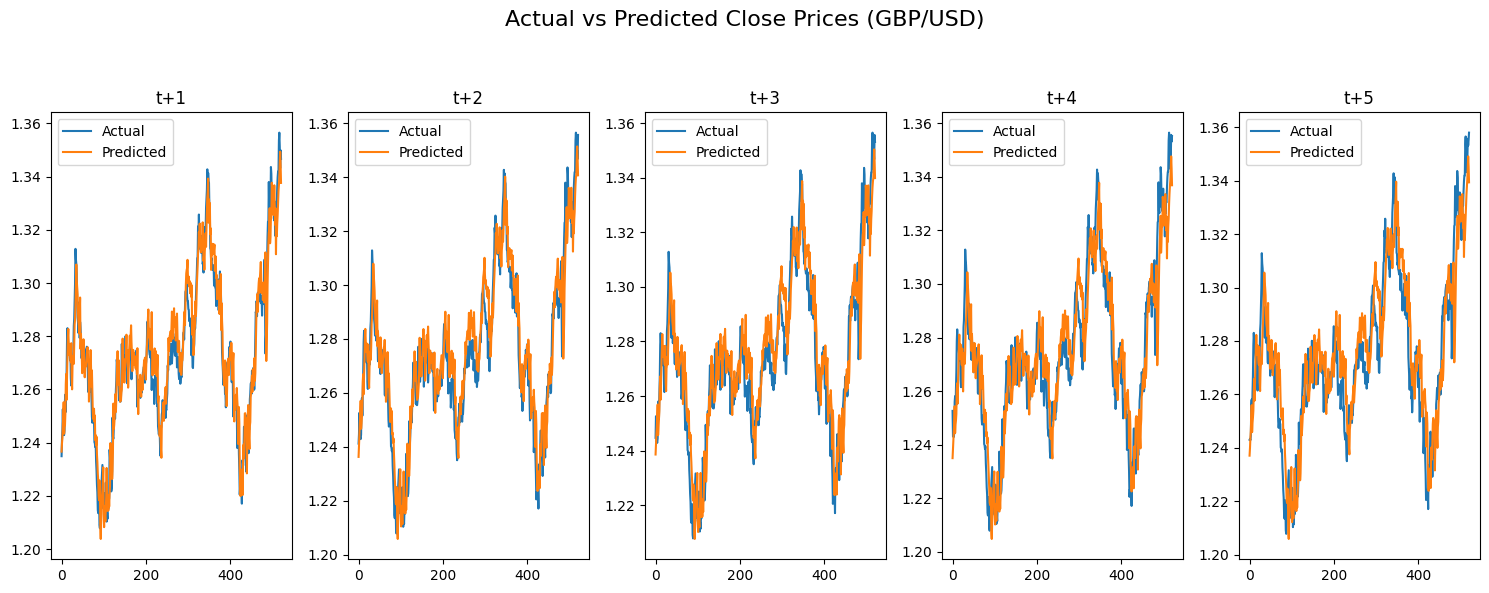

In [44]:
# Evaluasi
loss, mae = model_reg.evaluate(X_test_reg, y_test_reg)
print(f"Test Loss (MSE): {loss:.6f}, Test MAE: {mae:.6f}")

# Plot prediksi vs aktual
y_pred_reg = model_reg.predict(X_test_reg)

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(y_test_reg[:, i], label='Actual')
    plt.plot(y_pred_reg[:, i], label='Predicted')
    plt.title(f"t+{i+1}")  # judul untuk masing-masing subplot
    plt.legend()

plt.suptitle("Actual vs Predicted Close Prices (GBP/USD)", fontsize=16)  # satu judul utama
plt.tight_layout(rect=[0, 0, 1, 0.93])  # agar tidak menabrak suptitle
plt.show()


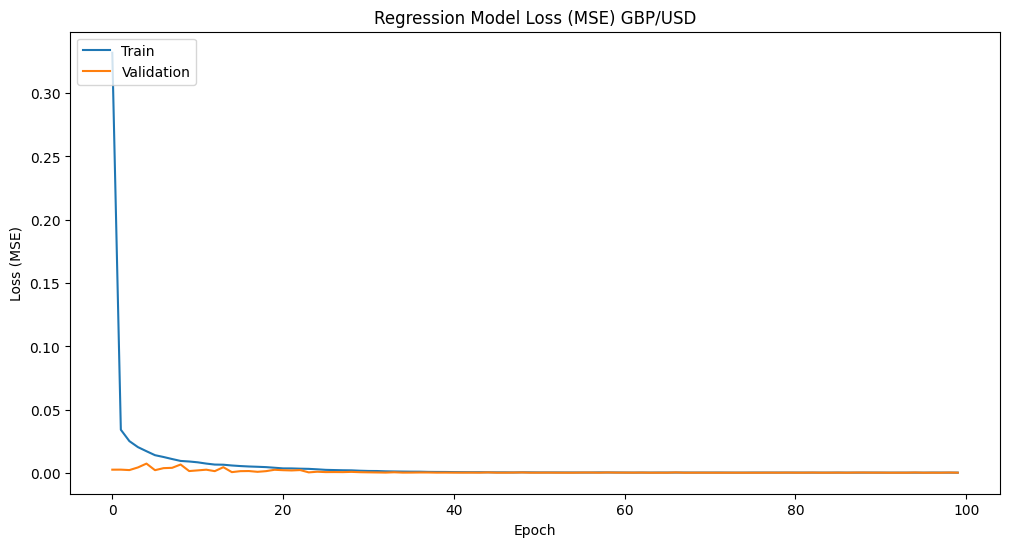

In [45]:
# Visualize training history (Regression Model)
plt.figure(figsize=(12, 6))

# Plot training & validation loss values for regression
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Regression Model Loss (MSE) GBP/USD')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Save Model

In [46]:
# Save model regresi
model_reg.save('GBPUSD_model_reg.h5')

# Inferensi

In [47]:
# Ambil window terakhir dari array features yang sudah disiapkan sebelumnya
latest_sequence = features[-window_size:]  # Shape (90, features)

# Ubah ke bentuk batch
X_latest = np.expand_dims(latest_sequence, axis=0).astype(np.float32)

# Get the last actual close price BEFORE scaling
last_actual_close = data['Close'].iloc[-window_size - 1] # Get the close price from the row *before* the latest sequence starts

# Prediksi probabilitas naik (tetap menggunakan model_cls)
y_pred_probs_cls = model_cls.predict(X_latest)
y_pred_cls = (y_pred_probs_cls > 0.5).astype(int)

# Prediksi harga penutupan (scaled, tetap menggunakan model_reg)
y_pred_price_scaled = model_reg.predict(X_latest)

# Kembalikan skala harga ke bentuk aslinya
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Function to inverse transform manual only for the Close column
def inverse_minmax(value, vmin, vmax):
    return value * (vmax - vmin) + vmin - 0.41

predicted_actual_prices = []
results = []
reference_price = last_actual_close # Start with the last actual close as the reference for t+1

print("📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):")
print("📈 Prediksi Harga Penutupan (Close) Pekan Depan:")

for i in range(5):
    # Inverse transform the predicted scaled price for the current day (t+i+1)
    predicted_scaled_price = y_pred_price_scaled[0, i]
    predicted_original_price_absolute = inverse_minmax(predicted_scaled_price, close_min, close_max)

    # Determine classification relative to the reference price (previous day's close or predicted close)
    classification = "Naik" if predicted_original_price_absolute > reference_price else "Turun"

    print(f"t+{i+1}: {classification} (Probabilitas: {y_pred_probs_cls[0, i]:.2f}), Prediksi Harga: {predicted_original_price_absolute:.5f}")

    result = {
        f"t+{i+1}": {
            "classification": classification,
            "classification_probability": float(y_pred_probs_cls[0, i]),
            "predicted_close_price": float(predicted_original_price_absolute)
        }
    }
    results.append(result)

    # Update the reference price for the next iteration
    reference_price = predicted_original_price_absolute


# Menyimpan hasil ke file JSON
output_filename = "GBPUSD_prediksi.json"
with open(output_filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nHasil prediksi klasifikasi dan harga telah disimpan ke {output_filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):
📈 Prediksi Harga Penutupan (Close) Pekan Depan:
t+1: Naik (Probabilitas: 0.64), Prediksi Harga: 1.35646
t+2: Naik (Probabilitas: 0.76), Prediksi Harga: 1.35734
t+3: Naik (Probabilitas: 0.88), Prediksi Harga: 1.35741
t+4: Turun (Probabilitas: 0.92), Prediksi Harga: 1.35576
t+5: Naik (Probabilitas: 0.93), Prediksi Harga: 1.35685

Hasil prediksi klasifikasi dan harga telah disimpan ke GBPUSD_prediksi.json
